<a href="https://colab.research.google.com/github/yajima-yasutoshi/Model/blob/main/20250723/%E6%96%BD%E8%A8%AD%E9%85%8D%E7%BD%AE%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#準備

In [ ]:
%%capture
# 必要なライブラリをインストール
!pip install mip japanize-matplotlib

#施設配置問題

本講義では、**施設配置問題 (Facility Location Problem)** について学びます。
この問題は、複数の候補地の中から施設（工場、倉庫、店舗、避難所、サーバーなど）を建設または設置する場所を選び、同時に各顧客（または需要地点）へどの施設からサービスを提供する（物資を配送するなど）のかを決定する最適化問題です。
目的は、施設の建設や運営にかかる固定費用と、施設から顧客へサービスを提供するための変動費用（輸送費など）の総和を最小にすることです。

**問題の主要な要素:**
* **施設 (Facilities):** 建設または設置が可能な候補地点。各候補地には施設を開設するための**固定の費用**が関連付けられます。
* **顧客 (Customers):** サービス提供を必要とする需要地点。
* **費用 (Costs):**
    * **固定費用 (Fixed Costs):** 各施設候補地に施設を開設する場合に一度だけ発生する費用（建設費、賃料、設備の導入費用など）。
    * **変動費用 (Variable Costs / Service Costs):** 開設された施設から各顧客へサービスを提供するために発生する費用（輸送費、距離や量に応じたサービス費用など）。

**目的:** どの施設候補地に施設を開設し、
各顧客へどの開設済みの施設からサービスを提供すれば、
固定費用と変動費用の合計が最小になるかを決定します。

**実社会での応用例:**
* **物流・サプライチェーン:** 倉庫や配送センターの最適配置、工場から倉庫への製品輸送ルートの最適化。
    * 例: 全国に商品を配送するために、どの都市に物流センターを建設し、各小売店をどのセンターから配送するのが最もコスト効率が良いか。
* **小売業:** 新規店舗の出店計画。どの地域に店舗を開設すれば、建設・運営コストと顧客への到達容易性のバランスを取りつつ、最大の利益（または最小コスト）を達成できるか。
* **公共サービス:** 避難所、消防署、病院、学校などの公共施設の配置計画。サービス提供の公平性や応答時間を考慮しつつ、限られた予算内で効果的な配置を目指す。
* **通信ネットワーク:** 携帯電話の基地局やデータセンターの配置。カバレッジや通信速度を最大化しつつ、設置コストを抑える。
* **製造業:** 新工場の建設場所の選定。原材料の調達コスト、製造コスト、製品の市場への輸送コストなどを総合的に考慮する。

この講義では、
特に**無容量施設配置問題 (Uncapacitated Facility Location Problem - UFLP)** と呼ばれる基本的なモデルを中心に扱います。これは、各施設がサービスを提供できる顧客数や量に上限がない（容量が無制限である）と仮定するモデルです。

---
### 定式化の詳細

ここでは、具体的な例題を通して無容量施設配置問題の定式化を行います。

####**例題**

ある企業が、複数の顧客にサービスを提供するために、いくつかの候補地の中から倉庫（施設）を建設することを計画しています。

* **施設候補地:** 3ヶ所 (F1, F2, F3)。各候補地には倉庫を開設するための固定費用があります。
* **顧客:** 4ヶ所 (C1, C2, C3, C4)。
* **輸送費用:** 各開設済み倉庫から各顧客へ商品を輸送するための費用が与えられています。

**データ:**
* **施設候補地と固定費用 ($f_i$):**
    * F1: 固定費用 100, 座標 (1, 5)
    * F2: 固定費用 120, 座標 (6, 6)
    * F3: 固定費用 80, 座標 (3, 1)
* **顧客の座標:**
    * C1: 座標 (1, 1)
    * C2: 座標 (2, 4)
    * C3: 座標 (5, 1)
    * C4: 座標 (4, 5)
* **輸送費用 ($c_{ij}$): 施設 $i$ から顧客 $j$ へ輸送する費用**

|       | C1 (1,1) | C2 (2,4) | C3 (5,1) | C4 (4,5) |
| :---- | :------: | :------: | :------: | :------: |
| F1 (1,5) |    20    |    10    |    50    |    30    |
| F2 (6,6) |    60    |    30    |    20    |    10    |
| F3 (3,1) |    10    |    40    |    15    |    50    |


#### 施設と顧客の配置の図示

問題を把握するために、施設候補地と顧客の位置をプロットしてみる。


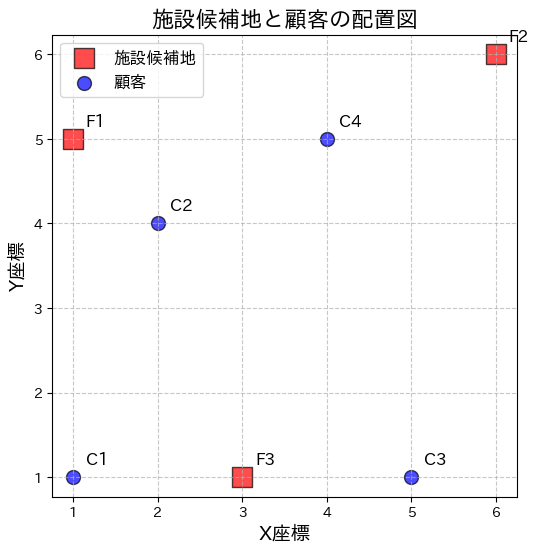

In [ ]:
#@title 配置の図示
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

# 施設データ
facilities_data = {
    'F1': {'coords': (1, 5), 'fixed_cost': 100},
    'F2': {'coords': (6, 6), 'fixed_cost': 120},
    'F3': {'coords': (3, 1), 'fixed_cost': 80}
}
facility_names = list(facilities_data.keys())
facility_coords = np.array([facilities_data[f]['coords'] for f in facility_names])

# 顧客データ
customers_data = {
    'C1': {'coords': (1, 1)},
    'C2': {'coords': (2, 4)},
    'C3': {'coords': (5, 1)},
    'C4': {'coords': (4, 5)}
}
customer_names = list(customers_data.keys())
customer_coords = np.array([customers_data[c]['coords'] for c in customer_names])

# プロット
plt.figure(figsize=(6, 6))
plt.scatter(facility_coords[:, 0], facility_coords[:, 1], marker='s', s=200, color='red', label='施設候補地', alpha=0.7, edgecolors='black')
for i, txt in enumerate(facility_names):
    plt.annotate(txt, (facility_coords[i, 0] + 0.15, facility_coords[i, 1] + 0.15), fontsize=12) # ラベル位置調整

plt.scatter(customer_coords[:, 0], customer_coords[:, 1], marker='o', s=100, color='blue', label='顧客', alpha=0.7, edgecolors='black')
for i, txt in enumerate(customer_names):
    plt.annotate(txt, (customer_coords[i, 0] + 0.15, customer_coords[i, 1] + 0.15), fontsize=12) # ラベル位置調整

plt.xlabel("X座標", fontsize=14)
plt.ylabel("Y座標", fontsize=14)
plt.title("施設候補地と顧客の配置図", fontsize=16)
plt.legend(fontsize=12, loc='upper left') # 凡例の位置調整
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal') # X軸とY軸のスケールを等しくする
plt.show()

#### 決定変数

この問題を数理モデルとして表現するために、以下の2種類の決定変数を定義します。

* $y_i \in \{0, 1\}$: 施設候補地 $i \in I =\{F1,F2,F3\}$ に施設を開設する場合は1、開設しない場合は0をとるバイナリ変数。
* $x_{ij} \in \{0, 1\}$: 顧客 $j \in \{C1, C2, C3, C4\}$ が施設 $i$ からサービスを受ける（に割り当てられる）場合は1、そうでない場合は0をとるバイナリ変数。

#### 目的関数

目的は、総費用（施設の固定費用と輸送費用の合計）を最小化することです。

$$\text{Minimize} \quad Z = \sum_{i \in I} f_i y_i + \sum_{i \in I} \sum_{j \in J} c_{ij} x_{ij}$$

ここで、
* $f_i$: 施設 $i$ を開設するための固定費用。
* $c_{ij}$: 施設 $i$ から顧客 $j$ へサービスを提供するための輸送費用。

#### 制約条件

1.  **顧客割り当て制約:** 各顧客 $j$ は、必ずいずれか1つの（開設された）施設に割り当てられなければなりません。
$$\sum_{i \in I} x_{ij} = 1 \quad \forall j \in J$$

2.  **施設開設連携制約:** 顧客 $j$ が施設 $i$ に割り当てられるのは、施設 $i$ が実際に開設されている場合のみです。
$$x_{ij} \le y_i \quad \forall i \in I, \forall j \in J$$
この制約は、もし施設 $i$ が開設されていない ($y_i=0$) ならば、どの顧客も施設 $i$ に割り当てられない ($x_{ij}=0$) ことを保証します。もし施設 $i$ が開設されている ($y_i=1$) ならば、$x_{ij}$ は0または1のいずれかの値を取り得ます。

3.  **変数型制約:**
$$y_i \in \{0, 1\} \quad \forall i \in I$$   $$x_{ij} \in \{0, 1\} \quad \forall i \in I, \forall j \in J$$

---
### 数理モデル（数式表記）

上記をまとめると、無容量施設配置問題（UFLP）の数理モデルは以下のように記述されます。

**集合とパラメータ:**
* $I$: 施設候補地の集合
* $J$: 顧客の集合
* $f_i$: 施設 $i \in I$ を開設するための固定費用
* $c_{ij}$: 施設 $i \in I$ から顧客 $j \in J$ へサービスを提供するための輸送費用

**決定変数:**
* $y_i$: 施設 $i \in I$ を開設するなら1、しないなら0
* $x_{ij}$: 顧客 $j \in J$ を施設 $i \in I$ に割り当てるなら1、しないなら0

**目的関数:**
$$\text{Minimize} \quad \sum_{i \in I} f_i y_i + \sum_{i \in I} \sum_{j \in J} c_{ij} x_{ij}$$

**制約条件:**
$$\sum_{i \in I} x_{ij} = 1 \quad \forall j \in J \quad \text{(各顧客は割り当てられる)}$$$$x_{ij} \le y_i \quad \forall i \in I, \forall j \in J \quad \text{(開設された施設からのみ割り当て)}$$$$y_i \in \{0, 1\} \quad \forall i \in I$$
$$x_{ij} \in \{0, 1\} \quad \forall i \in I, \forall j \in J$$

このモデルは混合整数線形計画問題（MILP）の一種です。


---
## Python MIP を用いた実装例

上の例題を `python-mip` を用いて解いてみる。

In [ ]:
import pandas as pd
from mip import Model, xsum, minimize, BINARY, OptimizationStatus
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語フォント対応
import numpy as np

# --- データ定義 ---
# 施設候補地
facilities = ['F1', 'F2', 'F3']
fixed_costs = {'F1': 100, 'F2': 120, 'F3': 80}
facility_coords_dict = {'F1': (1,5), 'F2': (6,6), 'F3': (3,1)} # 描画用

# 顧客
customers = ['C1', 'C2', 'C3', 'C4']
customer_coords_dict = {'C1':(1,1), 'C2':(2,4), 'C3':(5,1), 'C4':(4,5)} # 描画用

# 輸送費用 (facility, customer) -> cost
transport_costs = {
    ('F1', 'C1'): 20, ('F1', 'C2'): 10, ('F1', 'C3'): 50, ('F1', 'C4'): 30,
    ('F2', 'C1'): 60, ('F2', 'C2'): 30, ('F2', 'C3'): 20, ('F2', 'C4'): 10,
    ('F3', 'C1'): 10, ('F3', 'C2'): 40, ('F3', 'C3'): 15, ('F3', 'C4'): 50
}

# --- モデル作成 ---
model = Model("FacilityLocation")

# 決定変数
y = {i: model.add_var(var_type=BINARY, name=f"y_{i}") for i in facilities}
x = {(i, j): model.add_var(var_type=BINARY, name=f"x_{i}_{j}") for i in facilities for j in customers}

# 目的関数: 総費用の最小化
model.objective = minimize(
    xsum(fixed_costs[i] * y[i] for i in facilities) +
    xsum(transport_costs[i,j] * x[i,j] for i in facilities for j in customers)
)

# 制約条件
# 1. 各顧客は必ず1つの施設に割り当てられる
for j_cust in customers: # 変数名の衝突を避ける
    model += xsum(x[i_fac,j_cust] for i_fac in facilities) == 1, f"AssignCust_{j_cust}"

# 2. 顧客はその施設が開設されている場合にのみ割り当て可能
for i_fac in facilities:
    for j_cust in customers:
        model += x[i_fac,j_cust] <= y[i_fac], f"OpenFac_{i_fac}_{j_cust}"

# モデルの最適化
status = model.optimize()


# --- 結果の表示 ---
if status == OptimizationStatus.OPTIMAL:
    print(f"最適解が見つかりました。総費用: {model.objective_value:.2f}")

    opened_facilities = [i for i in facilities if y[i].x >= 0.99]
    print(f"開設された施設: {opened_facilities}")

    print("\n顧客の割り当て:")
    assignments = []
    for j_cust in customers:
        for i_fac in facilities:
            if x[i_fac,j_cust].x >= 0.99:
                print(f"  顧客 {j_cust} -> 施設 {i_fac} (輸送費用: {transport_costs[i_fac,j_cust]})")
                assignments.append({'customer': j_cust, 'facility': i_fac,
                                    'cust_coords': customer_coords_dict[j_cust],
                                    'fac_coords': facility_coords_dict[i_fac]})
elif status == OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")


最適解が見つかりました。総費用: 195.00
開設された施設: ['F3']

顧客の割り当て:
  顧客 C1 -> 施設 F3 (輸送費用: 10)
  顧客 C2 -> 施設 F3 (輸送費用: 40)
  顧客 C3 -> 施設 F3 (輸送費用: 15)
  顧客 C4 -> 施設 F3 (輸送費用: 50)


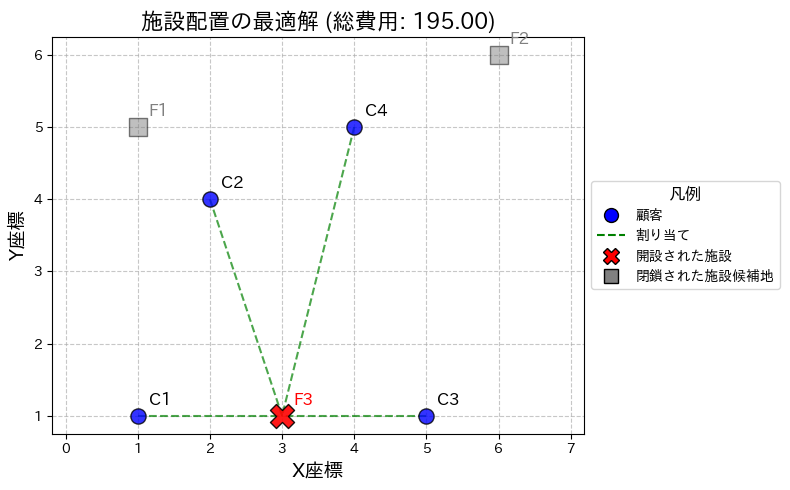

In [ ]:
#@title 結果の図示
if status == OptimizationStatus.OPTIMAL:
    # --- 結果の図示 ---
    plt.figure(figsize=(10, 5))

    # 施設候補地のプロット (色分け)
    facility_plot_coords_all = np.array([facility_coords_dict[f] for f in facilities])


    # 顧客のプロット
    customer_plot_coords_all = np.array([customer_coords_dict[c] for c in customers])
    plt.scatter(customer_plot_coords_all[:, 0], customer_plot_coords_all[:, 1],
                marker='o', s=120, color='blue', label='顧客', alpha=0.8, edgecolors='black', zorder=4)
    for idx, c_name in enumerate(customers):
        plt.annotate(c_name, (customer_plot_coords_all[idx, 0] + 0.15, customer_plot_coords_all[idx, 1] + 0.15), fontsize=12)


    legend_handles = [] # 凡例用ハンドル

    # 施設をプロット (開設された施設と閉鎖された候補地を区別)
    for i_fac_name in facilities:
        fac_coord = facility_coords_dict[i_fac_name]
        if i_fac_name in opened_facilities:
            p = plt.scatter(fac_coord[0], fac_coord[1], marker='X', s=300, color='red',
                        label=f'開設施設 ({i_fac_name})' if i_fac_name not in [h.get_label() for h in legend_handles] else "", # 重複を避ける
                        alpha=0.9, edgecolors='black', zorder=5)
            if p.get_label() != "": legend_handles.append(p)
            plt.annotate(i_fac_name, (fac_coord[0] + 0.15, fac_coord[1] + 0.15), fontsize=12, color='red', weight='bold')
        else:
            p = plt.scatter(fac_coord[0], fac_coord[1], marker='s', s=150, color='grey',
                        label=f'施設候補地 ({i_fac_name})' if i_fac_name not in [h.get_label() for h in legend_handles] else "",
                        alpha=0.5, edgecolors='black', zorder=5)
            if p.get_label() != "": legend_handles.append(p)
            plt.annotate(i_fac_name, (fac_coord[0] + 0.15, fac_coord[1] + 0.15), fontsize=12, color='grey')


    # 割り当て線の描画
    for assign in assignments:
        cust_coord_val = assign['cust_coords']
        fac_coord_val = assign['fac_coords']
        plt.plot([cust_coord_val[0], fac_coord_val[0]], [cust_coord_val[1], fac_coord_val[1]],
                 'g--', alpha=0.7, linewidth=1.5, zorder=3) #緑の破線

    # 顧客凡例のハンドル (手動で作成)
    customer_handle = plt.Line2D([0], [0], marker='o', color='w', label='顧客',
                                  markerfacecolor='blue', markeredgecolor='black', markersize=10)
    assignment_handle = plt.Line2D([0], [0], linestyle='--', color='g', label='割り当て', linewidth=1.5)

    # 既存の凡例と合わせて表示
    all_handles = [customer_handle, assignment_handle]
    # 開設/閉鎖施設の状態を表す凡例をスマートに追加
    if any(f in opened_facilities for f in facilities):
         all_handles.append(plt.Line2D([0], [0], marker='X', color='w', label='開設された施設', markerfacecolor='red', markersize=12, markeredgecolor='black'))
    if any(f not in opened_facilities for f in facilities):
         all_handles.append(plt.Line2D([0], [0], marker='s', color='w', label='閉鎖された施設候補地', markerfacecolor='grey', markersize=10, markeredgecolor='black'))


    plt.xlabel("X座標", fontsize=14)
    plt.ylabel("Y座標", fontsize=14)
    plt.title(f"施設配置の最適解 (総費用: {model.objective_value:.2f})", fontsize=16)
    plt.legend(handles=all_handles, title="凡例", fontsize=10, title_fontsize=12, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axis('equal')
    plt.tight_layout(rect=[0, 0, 0.8, 1]) # 凡例スペースを確保
    plt.show()

elif status == mip.OptimizationStatus.INFEASIBLE:
    print("実行不可能な問題です。制約を満たす解が存在しません。")
else:
    print(f"最適化が停止しました。ステータス: {status}")

#### 結果の解釈

上記のコードを実行すると、以下の情報が得られます。
* **総費用:** 最小化された目的関数の値。これが、この施設配置計画における最適な総コストです。
* **開設された施設:** $y_i=1$ となった施設のリスト。どの施設候補地に実際に施設を開設すべきかを示します。
* **顧客の割り当て:** 各顧客がどの開設済み施設からサービスを受けるか ($x_{ij}=1$ となった割り当て) と、その際の輸送費用。
* **結果の図示:** 地図上に、開設された施設（例：赤色のXマーカー）、閉鎖された施設候補地（例：灰色の四角マーカー）、顧客（例：青色の丸マーカー）、そして顧客と割り当てられた施設を結ぶ線が表示されます。これにより、地理的な関係性を含めて最適解を直感的に理解することができます。

---
### モデルの改善に関する簡単な視点

基本的な無容量施設配置問題は多くの状況で有用ですが、現実の多くの問題はさらに複雑な側面を持ちます。
* **施設容量の制約 (Capacitated Facility Location Problem - CFLP):** 各施設がサービスを提供できる顧客数や総需要量に上限（容量）がある場合。
* **複数種類の製品・サービス:** 施設が複数の製品を扱い、顧客が複数の製品を要求する場合。
* **階層的な施設配置:** 中央倉庫から地域配送センターへ、そこから顧客へ、といった階層構造を持つネットワークでの配置問題。
* **動的な施設配置:** 時間の経過とともに需要が変化したり、施設の開設・閉鎖のタイミングも考慮する問題。
* **確率的な要素の考慮:** 需要量や輸送費用が不確実性を持つ場合（確率計画や頑健最適化）。
* **最大カバレッジ問題 / k-メディアン問題 / k-センター問題:** 限られた数の施設で効果を最大化したり、顧客までの距離を最小化したりする問題。


---
#演習問題

##演習問題1

例題において、固定費用が、

* F1: 固定費用 10
* F2: 固定費用 12
* F3: 固定費用 8

と変更された場合、最適な施設配置における総コストを求めよ


##演習問題2

例題において、建設できる施設の最大数を $1$ 箇所に制限する場合、最適な施設配置を求め、総コストを解答せよ。


##演習問題3

例題において、施設F1は必ず建設しなければならない、という条件が加わった場合の総コストを解答せよ。


##演習問題4

例題に以下の条件を追加する。
* 各施設 $i$ が対応できる最大の顧客数 $K_i$ は以下の通りとする。
    * $K_0 = 3$ （施設0は最大3顧客まで対応可能）
    * $K_1 = 2$ （施設1は最大2顧客まで対応可能）
    * $K_2 = 2$ （施設2は最大2顧客まで対応可能）

この条件の下で、最適な総コストを求めよ。


##演習問題5

上の例題に、新しい施設建設候補地 F4 を追加する。
* 候補地 F4 の固定費 $f_{F4} = 90$
* 候補地 F4 から各顧客への輸送コスト $c_{F4,j} = [18, 12, 20, 10]$

この新しい候補地を含めて最適化した場合、総コストはいくつか。
